## Paso 0. Library import

In [2]:
!pip install flopy

# Flujo en 1D en MODFLOW 6.

**Tomado de**: MODFLOW 6 – Example problems, MODFLOW 6 Development Team, with contributions from Chieh Ying Chen and Mike Toews 02/07/2024.  **32 MOC3D Problem 1**. (Archivo: `mf6examples.pdf`).

**One-dimensional steady flow with transport**

* This problem corresponds to the first problem presented in the MOC3D report Konikow 1996 [1], involving the transport of a dissolved constituent in a steady, one-dimensional flow field.
* An analytical solution for this problem is given by Wexler [2].
* This example is simulated with the GWT Model in MODFLOW 6, **which receives flow information from a separate simulation with the GWF Model** in MODFLOW 6.
* Results from the GWT Model are compared with the results from the Wexler [2] analytical solution.

**<font color='Green'>[1] Konikow, L. F., Goode, D. J., & Hornberger, G. (1996). A three-dimensional method-of-characteristics solute-transport model (MOC3D). </font>** https://doi.org/10.3133/wri964267

**<font color='Green'>[2] Wexler, E. J. (1992). Analytical solution for one-, two-, and three-dimensional solute transport in ground-water systems with uniform flow; supplemental report; source codes for computer programs and sample data sets. U.S. Geological Survey Open File Report/Open-file Report.</font>** https://doi.org/10.3133/ofr9278

## Dominio de estudio.

<img src="./figures/mesh_plainview_mf6.png" width=300px hspace="5" vspace="5" style="float: right;"/>
<img src="./figures/mesh_3D_mf6.png" width=300px hspace="5" vspace="5" style="float: right;"/>

* The model grid for this problem consists of one layer, 120 columns, and 1 row.
* DELR is set to 0.1 $cm$ and DELC is specified with a constant value of 0.1 $cm$.
* The top for each cell is assigned a value of 1.0 $cm$ and the bottom is assigned a value of zero.

<img src="./figures/flow_mf6.png">

## Parámetros de la simulación.

* The simulation consists of one stress period that is 120 $s$ in length, and the stress period is divided into 240 equally sized time steps.
* By using a uniform porosity value of 0.1, a velocity value of 0.1 $cm/s$ results from the injection of water at a rate of 0.001 $cm^3/s$ into the first cell.
* The last cell is assigned a constant head with a value of zero, though this value is not important as the cells are marked as being confined.
* The concentration of the injected water is assigned a value of 1.0, and any water that leaves through the constant-head cell leaves with the simulated concentration of the water in that last cell.
* Advection is solved using the TVD scheme to reduce numerical dispersion.
  
|Parameter | Value| Units | Variable |
|---:|:---:|:---:|:---:|
|Number of periods |1| | `nper` |
|Number of layers |1| | `nlay` |
|Number of rows |1| | `nrow` |
|Number of columns |120| | `ncol` |
|Length of system |12.0| cm |
|Column width |0.1| cm |
|Row width |0.1| cm |
|Top of the model |1.0| cm |
|Layer bottom elevation (cm) |0| cm |
|Specific discharge |0.1| cm s$^{-1}$ |
|Hydraulic conductivity |0.01| cm s$^{-1}$ |
|Porosity of mobile domain |0.1| unitless |
|Simulation time |120.0| s |
|Source concentration |1.0| unitless |
|Initial concentration |0.0| unitless |





# MODFLOW 6.

## Componentes.

<img src="./figures/components_mf6.png">

Una simulación típicamente se basa en cuatro componentes:
* **Models**. Un modelo resuelve un proceso hidrológico; por ejemplo, el GWF model, resuelve la ecuación de flujo subterráneo usando el método CVFD.
* **Exchange**. Facilita la comunicación entre dos modelos; por ejemplo, un intercambio GWF-GWF, permite que algunas celdas de un modelo GWF estén hidráulicamente conectadas con celdas del otro modelo GWF.
* **Solutions**. Resuelve uno o más modelos hidrológicos, utiliza métodos iterativos para resolver sistemas no-lineales.
* **Timing**. Controla el paso de tiempo y determina el fin de una simulación.

**<font color='Green'>[3] Langevin, C.D., Hughes, J.D., Provost, A.M., Banta, E.R., Niswonger, R.G., and Panday, Sorab, 2017, Documentation for the MODFLOW 6 Groundwater Flow (GWF) Model: U.S. Geological Survey Techniques and Methods, book 6, chap. A55, 197 p., accessed August 4, 2017. </font>** https://doi.org/10.3133/tm6A55.

## Esquema para GWF.

<img src="./figures/modflow01.png" width=300px hspace="5" vspace="5" style="float: left;"/>

Taken from [4].

Figure 2. Schematic diagram showing several common ways in which the groundwater flow (GWF) and groundwatertransport (GWT) models can be configured within a simulation. The common use case depicted in (A) consists of a single    GWF model that is solved by a Numerical Solution. 


* The GWF Model described in [3] is divided into “packages,” as was done in previous MODFLOW versions.
* A package is the part of the model that deals with a single aspect of simulation.
* For example, the Well Package simulates the effect of wells, and the River Package simulates the effect of rivers.
* The GWF Model contains many packages and options that the user may or may not have occasion to use.


**<font color='Green'>[4] Langevin, C. D., Hughes, J. D., Provost, A. M., Russcher, M. J., & Panday, S. (2023). MODFLOW as a configurable Multi‐Model Hydrologic Simulator. Ground Water.</font>** https://doi.org/10.1111/gwat.13351

# Proceso de solución.

## Paso 1. Importación de bibliotecas

In [3]:
import os   # Intefaces con el sistema operativo.
import numpy as np # Manejo de arreglos numéricos multidimensionales
import matplotlib.pyplot as plt # Graficación

# Biblioteca y módulos de flopy
import flopy
from flopy.plot.styles import styles

## Paso 2. Ruta hacia el ejecutable de MODFLOW6 y nombre de la simulación.

In [4]:
ws = os.getcwd() # Ruta de donde estamos actualmente
mf6_exe = '/home/jovyan/GMMC/WMA/mf6/bin/mf6' # Ejecutable
name = 'flow' # Nombre de la simulación

print(' Ruta hacia el ejecutable de MODFLOW 6 : {} '.format(mf6_exe))
print(' Ruta actual : {}'.format(ws))
print(' Nombre de esta simulación: {}'.format(name))

 Ruta hacia el ejecutable de MODFLOW 6 : /home/jovyan/GMMC/WMA/mf6/bin/mf6 
 Ruta actual : /home/jovyan/GMMC/WMA/notebooks/1_Flujo_mf6_1D
 Nombre de esta simulación: flow


## Paso 3. Definición de la simulación (`MFSimulation` object)

**Recordemos que:**

<img src="./figures/modflow01.png" width=300px hspace="5" vspace="5" style="float: left;"/>

In [5]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=mf6_exe)
print(sim)

sim_name = flow
sim_path = /home/jovyan/GMMC/WMA/notebooks/1_Flujo_mf6_1D
exe_name = /home/jovyan/GMMC/WMA/mf6/bin/mf6

###################
Package mfsim.nam
###################

package_name = mfsim.nam
filename = mfsim.nam
package_type = nam
model_or_simulation_package = simulation
simulation_name = flow





## Paso 4. Definición de la discretización temporal (`ModflowTDis` object)

<center>
<img src="../figures/time_step.png" width=500px>
</center>
  
The length of a time step is calculated by multiplying the length of the previous time step by TSMULT. 
The length of the first time step, $\Delta t_1$, is related to PERLEN, NSTP, and TSMULT by the relation:
$$
\Delta t_1= \frac{\text{PERLEN}}{\text{NSTP}} \;\; \text{para} \;\; \text{TSMULT} = 1
$$

$$
\Delta t_1= \text{PERLEN} \frac{\text{TSMULT} - 1}{\text{TSMULT}^\text{nstp}-1} \;\; \text{para} \;\; \text{TSMULT} \neq 1
$$

The length of each successive time step is computed as

$$
\Delta t = \Delta t_{old} \text{TSMULT}
$$

where:
* `perlen` (double) is the length of a stress period.
* `nstp` (integer) is the number of time steps in a stress period.
* `tsmult` (double) is the multiplier for the length of successive time steps.
  
**<font color='Green'>[5] Hughes, J.D., Langevin, C.D., and Banta, E.R., 2017, *Documentation for the MODFLOW 6 framework: U.S. Geological Survey Techniques and Methods*, book 6, chap. A57, 40 p.,</font>** https://doi.org/10.3133/tm6A57. **Timing Module, pp 10,12**.

In [6]:
tparams = dict(nper = 1,  # Number of periods
               total_time = 120.0,  # Simulation time ($s$)
               nstp = 1.0,   # Number of time steps
               tsmult = 1.0  # Multiplier for the length of successive time steps.
              )
model_units = {}
model_units["time"] = "seconds"

In [7]:
flopy.mf6.ModflowTdis(sim, 
                      nper=tparams["nper"], 
                      perioddata=((tparams["total_time"], 
                                   tparams["nstp"], 
                                   tparams["tsmult"]),), 
                      time_units=model_units["time"])

package_name = flow.tdis
filename = flow.tdis
package_type = tdis
model_or_simulation_package = simulation
simulation_name = flow

Block options
--------------------
time_units
{internal}
('seconds')


Block dimensions
--------------------
nper
{internal}
(1)


Block perioddata
--------------------
perioddata
{internal}
(rec.array([(120., 1.0, 1.)],
          dtype=[('perlen', '<f8'), ('nstp', 'O'), ('tsmult', '<f8')]))



## Paso 5. Definición de la solución numérica (`ModflowIms` object)

In [8]:
ims = flopy.mf6.ModflowIms(sim)
print(ims)

package_name = ims_-1
filename = flow.ims
package_type = ims
model_or_simulation_package = simulation
simulation_name = flow




## GWF: Paquetes
Véase [3].

<img src="./figures/gwf_mf6.png" width=500px hspace="5" vspace="5" style="float: left;"/>
<img src="./figures/gwf_mf6_pack.png" width=500px hspace="5" vspace="5" style="float: left;"/>

## Paso 6. Modelo de Flujo (ModflowGwf object)

In [9]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)
print(gwf)

name = flow
model_type = gwf6
version = mf6
model_relative_path = .




## Paso 7. Paquete: discretización espacial (`ModflowGwfdis` object)

In [11]:
# Bibliotecas construidas para este proyecto
import vflow

mesh = vflow.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 120,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 12.0,    # Length of system ($cm$)
    column_length = 0.1,  # Length of system ($cm$)
    top = 1.0,   # Top of the model ($cm$)
    bottom = 0,  # Layer bottom elevation ($cm$)
)

model_units["length"] = "centimeters"
print(mesh.delr, ' Column width ', model_units["length"])
print(mesh.delc, ' Row width ', model_units["length"])

0.1  Column width  centimeters
0.1  Row width  centimeters


In [12]:
dis = flopy.mf6.ModflowGwfdis(gwf,
                              length_units=model_units["length"],
                              nlay=mesh.nlay,
                              nrow=mesh.nrow,
                              ncol=mesh.ncol,
                              delr=mesh.delr,
                              delc=mesh.delc,
                              top=mesh.top,
                              botm=mesh.bottom,
)
print(dis)

package_name = dis
filename = flow.dis
package_type = dis
model_or_simulation_package = model
model_name = flow

Block options
--------------------
length_units
{internal}
(centimeters)


Block dimensions
--------------------
nlay
{internal}
(1)

nrow
{internal}
(1)

ncol
{internal}
(120)


Block griddata
--------------------
delr
{constant 0.1}

delc
{constant 0.1}

top
{constant 1.0}

botm
{constant 0}





## Paso 8. Paquete: condiciones iniciales (`ModflowGwfic` object)

In [13]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=1.0)
print(ic)

package_name = ic
filename = flow.ic
package_type = ic
model_or_simulation_package = model
model_name = flow

Block griddata
--------------------
strt
{constant 1.0}





## Paso 9. Paquete: propiedades de flujo en los nodos (`ModflowGwfnpd` object)

In [15]:
## Physical parameters
pparams = {}
pparams["hydraulic_conductivity"] = 0.01  # Hydraulic conductivity ($cm s^{-1}$)

In [16]:
npf = flopy.mf6.ModflowGwfnpf(gwf,
                              save_specific_discharge=True,
                              save_saturation=True,
                              icelltype=0,
                              k=pparams["hydraulic_conductivity"],
)
print(npf)

package_name = npf
filename = flow.npf
package_type = npf
model_or_simulation_package = model
model_name = flow

Block options
--------------------
save_specific_discharge
{internal}
(True)

save_saturation
{internal}
(True)


Block griddata
--------------------
icelltype
{constant 0}

k
{constant 0.01}





## Paso 10. Paquete: CHD (`ModflowGwfchd` object)

In [17]:
chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=[[(0, 0, mesh.ncol - 1), 1.0]]) 
print(chd)

package_name = chd_0
filename = flow.chd
package_type = chd
model_or_simulation_package = model
model_name = flow

Block period
--------------------
stress_period_data
{0: <flopy.mf6.data.mfdataplist.PandasListStorage object at 0x7fac3c89a610>}




## Paso 11. Paquete: Pozos (`ModflowGwfwel` object)

In [18]:
pparams["specific_discharge"] = 0.1  # Specific discharge ($cm s^{-1}$)
pparams["source_concentration"] = 1.0  # Source concentration (unitless)

In [19]:
q = pparams["specific_discharge"] * mesh.delc * mesh.delr * mesh.top
aux = pparams["source_concentration"]
wel = flopy.mf6.ModflowGwfwel(gwf,
                              stress_period_data=[[(0, 0, 0), q, aux,]],
                              pname="WEL-1",
                              auxiliary=["CONCENTRATION"],
)

print(wel)

package_name = wel-1
filename = flow.wel
package_type = wel
model_or_simulation_package = model
model_name = flow

Block options
--------------------
auxiliary
{internal}
([('auxiliary', 'CONCENTRATION')])


Block period
--------------------
stress_period_data
{0: <flopy.mf6.data.mfdataplist.PandasListStorage object at 0x7fac3c8d5d50>}




## Paso 12. Paquete: salida (`ModflowGwfoc` object)

In [20]:
head_filerecord = f"{name}.hds"
budget_filerecord = f"{name}.bud"
oc = flopy.mf6.ModflowGwfoc(gwf,
                            head_filerecord=head_filerecord,
                            budget_filerecord=budget_filerecord,
                            saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)
print(oc)

package_name = oc
filename = flow.oc
package_type = oc
model_or_simulation_package = model
model_name = flow

Block options
--------------------
budget_filerecord
{internal}
([('flow.bud',)])

head_filerecord
{internal}
([('flow.hds',)])


Block period
--------------------
saverecord
{internal}
([('HEAD', 'ALL', None) ('BUDGET', 'ALL', None)])

printrecord
None




## Paso 13. Escritura de los archivos de entrada para MODFLOW 6

In [21]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model flow...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 1 based on size of stress_period_data
    writing package wel-1...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


## Paso 14. Ejecución de la simulación.

In [22]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../mf6/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.4.4 02/13/2024

   MODFLOW 6 compiled Feb 13 2024 16:19:58 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall

(True, [])

## Paso 15. Postprocessing

In [23]:
# Obtenemos los resultados de la carga hidráulica
head = flopy.utils.HeadFile(os.path.join(ws, head_filerecord)).get_data()

# Obtenemos los resultados del BUDGET
bud  = flopy.utils.CellBudgetFile(os.path.join(ws, budget_filerecord),
                                  precision='double')
# Obtenemos las velocidades
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

In [24]:
# Verificamos el tipo y dimensiones de los arreglos donde
# están almacenados la carga hidráulica, el BUDGET, y la velocidad.
print('Head : ', type(head), head.shape)
print('Budget : ', type(bud), bud.shape)
print('spdis : ', type(spdis), spdis.shape)
print('qx : ', type(qx), qx.shape)
print('qy : ', type(qy), qy.shape)
print('qz : ', type(qz), qz.shape)

Head :  <class 'numpy.ndarray'> (1, 1, 120)
Budget :  <class 'flopy.utils.binaryfile.CellBudgetFile'> (1, 1, 120)
spdis :  <class 'numpy.recarray'> (120,)
qx :  <class 'numpy.ndarray'> (1, 1, 120)
qy :  <class 'numpy.ndarray'> (1, 1, 120)
qz :  <class 'numpy.ndarray'> (1, 1, 120)


In [25]:
print(head.shape, '\n', head)

(1, 1, 120) 
 [[[12.9 12.8 12.7 12.6 12.5 12.4 12.3 12.2 12.1 12.  11.9 11.8 11.7 11.6
   11.5 11.4 11.3 11.2 11.1 11.  10.9 10.8 10.7 10.6 10.5 10.4 10.3 10.2
   10.1 10.   9.9  9.8  9.7  9.6  9.5  9.4  9.3  9.2  9.1  9.   8.9  8.8
    8.7  8.6  8.5  8.4  8.3  8.2  8.1  8.   7.9  7.8  7.7  7.6  7.5  7.4
    7.3  7.2  7.1  7.   6.9  6.8  6.7  6.6  6.5  6.4  6.3  6.2  6.1  6.
    5.9  5.8  5.7  5.6  5.5  5.4  5.3  5.2  5.1  5.   4.9  4.8  4.7  4.6
    4.5  4.4  4.3  4.2  4.1  4.   3.9  3.8  3.7  3.6  3.5  3.4  3.3  3.2
    3.1  3.   2.9  2.8  2.7  2.6  2.5  2.4  2.3  2.2  2.1  2.   1.9  1.8
    1.7  1.6  1.5  1.4  1.3  1.2  1.1  1. ]]]


In [26]:
print(qx.shape, '\n', qx)

(1, 1, 120) 
 [[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


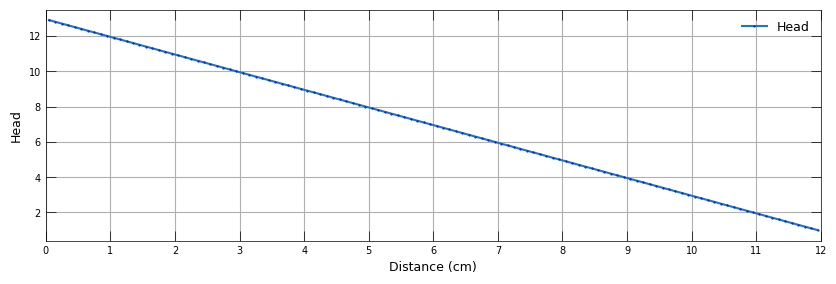

In [28]:
with styles.USGSPlot():
    plt.rcParams['font.family'] = 'DeJavu Sans'
    x, _, _ = mesh.get_coords()
    plt.figure(figsize=(10,3))
    plt.plot(x, head[0, 0], marker=".", ls ="-", mec="blue", mfc="none", markersize="1", label = 'Head')
    plt.xlim(0, 12)
    plt.xticks(ticks=np.linspace(0, mesh.row_length,13))
    plt.xlabel("Distance (cm)")
    plt.ylabel("Head")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
plt.figure(figsize=(10,0.15))
ax = plt.gca()
#ax.set_aspect('equal')
pmv0 = flopy.plot.PlotMapView(gwf, ax=ax)
pmv0.plot_grid(colors='dimgray', lw=0.5)
plt.yticks(ticks=[0, 0.1],fontsize=8)

plt.show()


# 